In [1]:
import torch
from torch import nn
import pybuda
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("dyllanesl/ASL_Classifier")
model = AutoModelForImageClassification.from_pretrained("dyllanesl/ASL_Classifier")

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
tt0 = pybuda.TTDevice(
    name="tt_device_0",  # here we can give our device any name we wish, for tracking purposes
    arch=pybuda.BackendDevice.Grayskull
)

In [4]:
# Create module
pybuda_module = pybuda.PyTorchModule(
    name = "asl_model",  # give the module a name, this will be used for tracking purposes
    module=model  # specify the model that is being targeted for compilation
)

# Place module on device
tt0.place_module(module=pybuda_module)

In [5]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset('raulit04/ASL_Dataset1')['train']

Using custom data configuration raulit04--ASL_Dataset1-d033ce9363c88848
Reusing dataset parquet (/home/user/.cache/huggingface/datasets/raulit04___parquet/raulit04--ASL_Dataset1-d033ce9363c88848/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)
100%|██████████| 1/1 [00:00<00:00, 501.17it/s]


In [6]:
# Create a mapping from labels to IDs
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for idx, label in enumerate(label_to_id)}

In [7]:
import os
compiler_cfg = pybuda.config._get_global_compiler_config()
compiler_cfg.balancer_policy = "Ribbon"
compiler_cfg.default_df_override = pybuda.DataFormat.Float32


In [8]:
def setup_image(image: Image):
    image.convert("RGB")
    processed_tensor = processor(images=image, return_tensors='pt')
    return processed_tensor['pixel_values']

In [9]:
def get_prediction_given_tensor(input_tensor):
    tt0.push_to_inputs((input_tensor,))
    output_q = pybuda.run_inference()
    output = output_q.get()
    output_tensor = output[0].value()
    pred = output_tensor.argmax(-1).item()
    return id_to_label[pred]

In [16]:
image_0 = Image.open(str(Path(os.path.abspath('.')) / 'dataset_tenstorrent_images' / '2.png'))
image_tensor = setup_image(image_0)

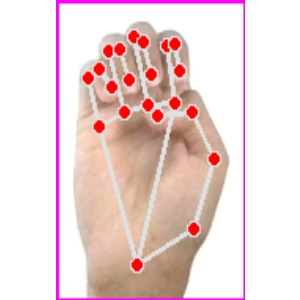

In [30]:
display(image_0)

In [31]:

tt0.push_to_inputs((image_tensor,))
output_q = pybuda.run_inference()
output = output_q.get()

2024-08-03 05:27:31.293 | DEBUG    | pybuda.run.impl:_run_forward:644 - Running concurrent device forward: TTDevice 'tt_device_0'


2024-08-03 05:27:31.299 | INFO     | Runtime         - Running program 'run_fwd_0' with params [("$p_loop_count", "1")]


2024-08-03 05:27:31.297 | DEBUG    | pybuda.device:run_next_command:429 - Received RUN_FORWARD command on TTDevice 'tt_device_0' / 798048
2024-08-03 05:27:31.297 | DEBUG    | pybuda.ttdevice:forward:906 - Starting forward on TTDevice 'tt_device_0'
2024-08-03 05:27:31.298 | DEBUG    | pybuda.backend:feeder_thread_main:171 - Run feeder thread cmd: fwd
2024-08-03 05:27:31.300 | DEBUG    | pybuda.backend:read_queues:345 - Reading output queue asl_model.output_add_636
2024-08-03 05:27:31.301 | DEBUG    | pybuda.device_connector:pusher_thread_main:163 - Pusher thread pushing tensors
2024-08-03 05:27:31.302 | DEBUG    | pybuda.backend:push_to_queues:452 - Pushing to queue pixel_values
2024-08-03 05:27:31.367 | DEBUG    | pybuda.backend:read_queues:415 - Done reading queues
2024-08-03 05:27:31.368 | DEBUG    | pybuda.backend:pop_queues:421 - Popping from queue asl_model.output_add_636


In [32]:
output[0].value()

tensor([[ 7.8516e-01,  3.5352e-01, -7.4219e-01,  1.2812e+00,  1.1938e+01,
          2.8516e-01,  6.1719e-01, -6.0547e-01,  7.0190e-03, -7.2266e-01,
         -3.2812e-01,  4.8633e-01,  6.2500e-01, -1.6719e+00, -1.6250e+00,
         -5.4688e-01,  2.4609e-01, -4.5703e-01, -1.8359e+00,  5.3516e-01,
         -8.5938e-01, -3.9648e-01, -2.6719e+00, -1.5312e+00, -1.2656e+00,
         -7.7344e-01]], dtype=torch.bfloat16, requires_grad=True)

In [33]:
output[0].value().argmax().item()

4

In [34]:
id_to_label[output[0].value().argmax().item()]

'E'

In [22]:
def get_all_file_abspaths(directory):
    files = sorted([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    return [os.path.abspath(os.path.join(directory, f)) for f in files]

In [ ]:
output_letters = []
output_images = []
#going through the hand made dataset
for image_path in get_all_file_abspaths(str(Path(os.path.abspath('.')) / 'cropped_tenstorrent_images')):
    image = Image.open(image_path)
    output_images.append(image)
    readied_tensor = setup_image(image)
    guessed_label = get_prediction_given_tensor(readied_tensor)
    output_letters.append(guessed_label)

In [ ]:
for (letter, image) in zip(output_letters, output_images):
    print('Guessed letter:', letter)
    print('Image')
    display(image)

In [ ]:
print('desired word: ', 'Tenstorrent')
print('Guessed word: ', ''.join(output_letters))

In [ ]:
#going through the hugging face dataset
dataset_length = len(dataset['image'])
correct = 0
for i, (image, label) in enumerate(zip(dataset['image'], dataset['label'])):
    if i == 0:
        print('image: ')
        display(image)
    readied_tensor = setup_image(image)
    guessed_label = get_prediction_given_tensor(readied_tensor)
    
    if i < 5:
        print('actual label: ', label, ' guessed label: ', guessed_label)
    if i ==5:
        print("you get the deal. I'll just print out the accuracy")
    correct += 1 if label == guessed_label else 0
    # break

print('accuracy: ', correct/dataset_length)

In [ ]:
output_letters = []
output_images = []
#going through the cherry picked dataset
for image_path in get_all_file_abspaths(str(Path(os.path.abspath('.')) / 'dataset_tenstorrent_images')):
    image = Image.open(image_path)
    output_images.append(image)
    readied_tensor = setup_image(image)
    guessed_label = get_prediction_given_tensor(readied_tensor)
    output_letters.append(guessed_label)

Guessed letter: T
Image


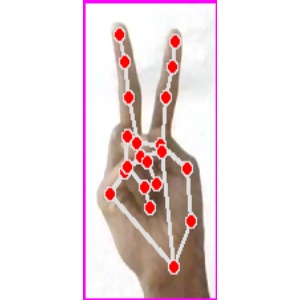

Guessed letter: E
Image


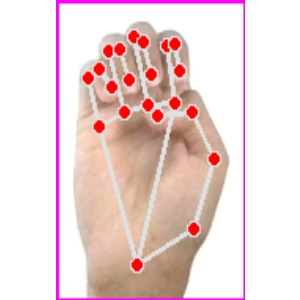

Guessed letter: N
Image


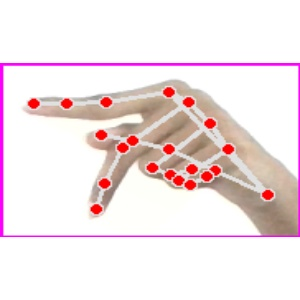

Guessed letter: S
Image


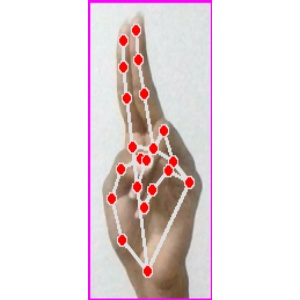

Guessed letter: T
Image


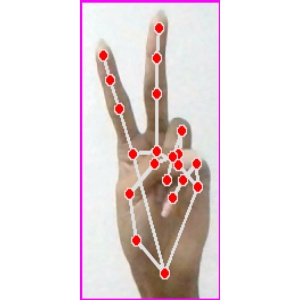

Guessed letter: O
Image


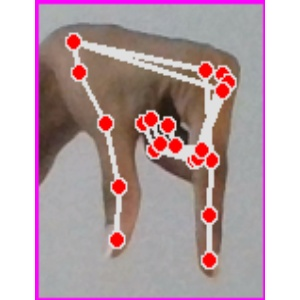

Guessed letter: R
Image


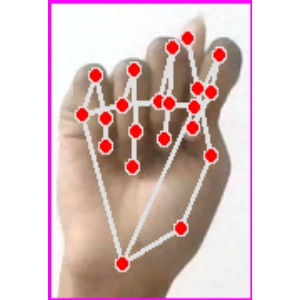

Guessed letter: R
Image


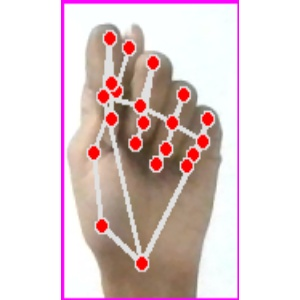

Guessed letter: E
Image


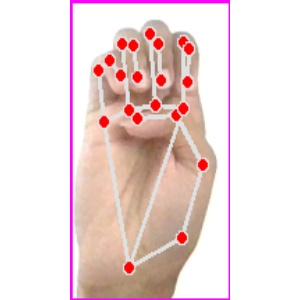

Guessed letter: N
Image


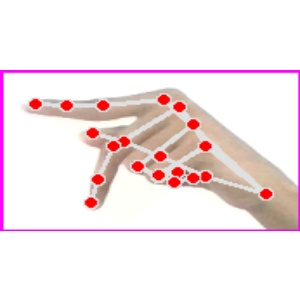

Guessed letter: T
Image


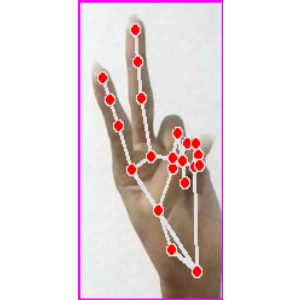

In [36]:
for (letter, image) in zip(output_letters, output_images):
    print('Guessed letter:', letter)
    print('Image')
    display(image)

In [37]:
print('desired word: ', 'Tenstorrent')
print('Guessed word: ', ''.join(output_letters))

desired word:  Tenstorrent
Guessed word:  TENSTORRENT


2024-08-03 05:28:44.487 | INFO     | Runtime         - Reading debug mailbox for device 0, output yaml path /tmp/user/326f2b96a398/perf_results//debug_mailbox_device_0.yaml
2024-08-03 05:28:44.534 | ERROR    | Always          - Device runtime exceeded timeout of 500 seconds, a possible hang is detected. TT_BACKEND_TIMEOUT=<value> envvar can be used to increase the timeout.


terminate called after throwing an instance of 'tt::error_types::timeout_error'
  what():  Device runtime exceeded timeout of 500 seconds, a possible hang is detected.


In [ ]:
pybuda.shutdown()

In [ ]:
tt0.remove_modules()